In [1]:
%matplotlib inline


Autograd: Automatic Differentiation
===================================

Central to all neural networks in PyTorch is the ``autograd`` package.
Let’s first briefly visit this, and we will then go to training our
first neural network.


The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a define-by-run framework, which means that your backprop is
defined by how your code is run, and that every single iteration can be
different.

Let us see this in more simple terms with some examples.

Tensor
--------

``torch.Tensor`` is the central class of the package. If you set its attribute
``.requires_grad`` as ``True``, it starts to track all operations on it. When
you finish your computation you can call ``.backward()`` and have all the
gradients computed automatically. The gradient for this tensor will be
accumulated into ``.grad`` attribute.

To stop a tensor from tracking history, you can call ``.detach()`` to detach
it from the computation history, and to prevent future computation from being
tracked.

To prevent tracking history (and using memory), you can also wrap the code block
in ``with torch.no_grad():``. This can be particularly helpful when evaluating a
model because the model may have trainable parameters with `requires_grad=True`,
but for which we don't need the gradients.

There’s one more class which is very important for autograd
implementation - a ``Function``.

``Tensor`` and ``Function`` are interconnected and build up an acyclic
graph, that encodes a complete history of computation. Each tensor has
a ``.grad_fn`` attribute that references a ``Function`` that has created
the ``Tensor`` (except for Tensors created by the user - their
``grad_fn is None``).

If you want to compute the derivatives, you can call ``.backward()`` on
a ``Tensor``. If ``Tensor`` is a scalar (i.e. it holds a one element
data), you don’t need to specify any arguments to ``backward()``,
however if it has more elements, you need to specify a ``gradient``
argument that is a tensor of matching shape.



In [2]:
import torch

Create a tensor and set requires_grad=True to track computation with it



In [3]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[ 1.,  1.],
        [ 1.,  1.]])


Do an operation of tensor:



In [4]:
y = x + 2
print(y)

tensor([[ 3.,  3.],
        [ 3.,  3.]])


``y`` was created as a result of an operation, so it has a ``grad_fn``.



In [5]:
print(y.grad_fn)

Do more operations on y



In [6]:
z = y * y * 3
out = z.mean()
q=x**2
print(z, out)
print(q, out)

(tensor([[ 27.,  27.],
        [ 27.,  27.]]), tensor(27.))
(tensor([[ 1.,  1.],
        [ 1.,  1.]]), tensor(27.))


``.requires_grad_( ... )`` changes an existing Tensor's ``requires_grad``
flag in-place. The input flag defaults to ``False`` if not given.



In [7]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

False
True


### We use a little tool to draw the list of operation on the computation graph

https://github.com/szagoruyko/pytorchviz

It produces Graphviz representation of PyTorch autograd graph.
* Blue nodes are the Variables that require grad, 
* orange are Tensors saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that require grad


In [8]:
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-VGCcX9
  Running setup.py bdist_wheel for pytorchviz ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-rvfPxZ/wheels/b9/b9/85/ef34936f58754cb23840fd869be1367b5d525e29915a2a4fe9
Successfully built pytorchviz
mkl-random 1.0.1 requires cython, which is not installed.
mkl-fft 1.0.0 requires cython, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


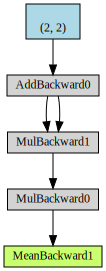

In [15]:
from torchviz import make_dot
# we neglect the parameter here which defines the names
# the tool is meant for ploting models
make_dot(out) 

Gradients
---------
Let's backprop now
Because ``out`` contains a single scalar, ``out.backward()`` is
equivalent to ``out.backward(torch.tensor(1))``.



In [16]:
out.backward()

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

print gradients d(out)/dx




In [17]:
print(x.grad)

tensor([[ 4.5000,  4.5000],
        [ 4.5000,  4.5000]])


You should have got a matrix of ``4.5``. Let’s call the ``out``
*Tensor* “$o$”.
We have that $o = \frac{1}{4}\sum_i z_i$,
$z_i = 3(x_i+2)^2$ and $z_i\bigr\rvert_{x_i=1} = 27$.
Therefore,
$\frac{\partial o}{\partial x_i} = \frac{3}{2}(x_i+2)$, hence
$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=1} = \frac{9}{2} = 4.5$.



<hr>
Another simple example
$L=\sum_{i=0}^4 a_i^2$

$\frac{dL}{d\vec{\,a}}=grad(L)=2\vec{\,a}$

In [18]:
a=torch.tensor([1.,2.,3.,4.,5.],requires_grad=True)
L=torch.sum(a*a) 
L.backward()
print L
print a.grad

tensor(55.)
tensor([  2.,   4.,   6.,   8.,  10.])


<hr>
You can do many crazy things with autograd!

What you run is what you differentiate.



tensor([ 1.4525,  0.7458,  0.4350])
tensor([ 5.8100,  2.9832,  1.7401])
tensor([ 11.6201,   5.9663,   3.4803])
tensor([ 23.2402,  11.9326,   6.9605])
tensor([ 46.4803,  23.8652,  13.9211])
tensor([ 92.9606,  47.7304,  27.8422])
tensor([ 185.9212,   95.4608,   55.6844])
tensor([ 371.8424,  190.9216,  111.3687])
tensor([ 743.6848,  381.8432,  222.7374])
tensor([ 1487.3696,   763.6865,   445.4749])
tensor(1730.2986)


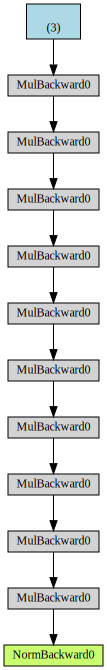

In [25]:
x = torch.randn(3, requires_grad=True)
print x
y = x * 2
while y.data.norm() < 1000:
    y = y * 2
    print y
y=y.norm()
print(y)
make_dot(y)

In [20]:
y.backward()
print(x.grad)

tensor([ 476.4026,  102.6742, -156.9793])


You can also stop autograd from tracking history on Tensors
with ``.requires_grad``=True by wrapping the code block in
``with torch.no_grad():``



In [21]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
	print((x ** 2).requires_grad)

True
True
False


**Read Later:**

Documentation of ``autograd`` and ``Function`` is at
http://pytorch.org/docs/autograd

The backward argument can be used to select which part of the of the final object is considered

In [27]:
?torch.mm

Docstring:
mm(mat1, mat2, out=None) -> Tensor

Performs a matrix multiplication of the matrices :attr:`mat1` and :attr:`mat2`.

If :attr:`mat1` is a :math:`(n \times m)` tensor, :attr:`mat2` is a
:math:`(m \times p)` tensor, :attr:`out` will be a :math:`(n \times p)` tensor.

.. note:: This function does not :ref:`broadcast <broadcasting-semantics>`.
          For broadcasting matrix products, see :func:`torch.matmul`.

Args:
    mat1 (Tensor): the first matrix to be multiplied
    mat2 (Tensor): the second matrix to be multiplied
    out (Tensor, optional): the output tensor

Example::

    >>> mat1 = torch.randn(2, 3)
    >>> mat2 = torch.randn(3, 3)
    >>> torch.mm(mat1, mat2)
    tensor([[ 0.4851,  0.5037, -0.3633],
            [-0.0760, -3.6705,  2.4784]])
Type:      builtin_function_or_method


In [28]:
A=torch.tensor([[1.,2.],[3.,4.]],requires_grad=True)
print 'A',A
B=torch.mm(A,A)
print 'B',B
l=B[0,0]
l.backward() # this is unique, l is 1-dim we do not need an argument
#B[0,0] depends on A[0,0],A[1,0] and A[0,1] but not on A[1,1]
#therefor A.grad[1,1] is zero
print A.grad
# the same but for l.shape=(2,2)
A=torch.tensor([[1.,2.],[3.,4.]],requires_grad=True)
print '\nA',A
B=torch.mm(A,A)
print 'B',B
l=B
# now l is not a scalar but a 2x2 tensor
# the chain of derivatives is multiplied with the backward argument
# This allows to combine derivative calculations or here to select some gradient 
l.backward(torch.tensor([[1.,0],[0,0]])) 
print A.grad
print l.backward()

A tensor([[ 1.,  2.],
        [ 3.,  4.]])
B tensor([[  7.,  10.],
        [ 15.,  22.]])
tensor([[ 2.,  3.],
        [ 2.,  0.]])

A tensor([[ 1.,  2.],
        [ 3.,  4.]])
B tensor([[  7.,  10.],
        [ 15.,  22.]])
tensor([[ 2.,  3.],
        [ 2.,  0.]])


RuntimeError: grad can be implicitly created only for scalar outputs

### We can also get higher derivatives

torch.autograd.grad can be used to calculate derivatives of functions and can be used to define second or higher derivatives

In [52]:
%%timeit
x = torch.tensor(2., requires_grad=True)
y = x * x
z = x * y
#print z
z.backward()
# more precise
#z.backward(torch.ones_like(x))
#print x.grad
x.grad

10000 loops, best of 3: 84.4 µs per loop


In [40]:
%%timeit
# torch.autograd.grad for higher derivatives
# a scalar
x = torch.tensor(2., requires_grad=True)
y=x**3
# The following is now not working!
# y.backward()
#print 'x',x,'- x.grad',x.grad
#print 'y',y
#print '--- grad ---'
# autograd.grad() can create graph as any other operation that can be passed by x.backward later
a=torch.autograd.grad(outputs=y, inputs=x, create_graph=True)[0] # 3*x**2 returns a 1-dim list
#print 'a',a
#print 'x',x,'- x.grad',x.grad
#not need x.grad.data.zero_()
#print '--- backward ---'
a.backward() # 2*3*x - x,grad is now second derivative
#print 'x',x,'- x.grad',x.grad
x.grad

10000 loops, best of 3: 147 µs per loop


In [42]:
# torch.autograd.grad for higher derivatives
# 1d now for tanh(x)
x = torch.tensor(2., requires_grad=True)
y=torch.tanh(x)
print 'x',x,'- x.grad',x.grad
print 'y',y
print '--- grad ---'
# create graph as any other operation that can be passed by x.backward later
a=torch.autograd.grad(outputs=y, inputs=x, create_graph=True)[0] # 3*x**2 returns a 1-dim list
print 'a',a
print 'x',x,'- x.grad',x.grad
#not need x.grad.data.zero_()
print '--- backward ---'
d=torch.ones_like(x)
a.backward(d) # 2*3*x - x,grad is now second derivative
print 'x',x,'- x.grad',x.grad,d

x tensor(2.) - x.grad None
y tensor(0.9640)
--- grad ---
a tensor(1.00000e-02 *
       7.0651)
x tensor(2.) - x.grad None
--- backward ---
x tensor(2.) - x.grad tensor(-0.1362) tensor(1.)


In [43]:
import torch
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from torch.autograd import grad

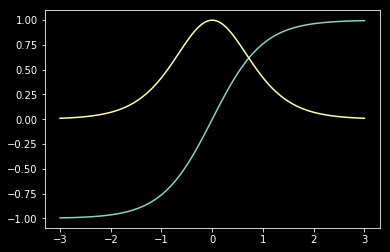

In [47]:
# function and first derivative
xrange=np.linspace(-3,3,100)
x=torch.tensor(xrange,requires_grad=True)
y=torch.tanh(x)
y.backward(torch.ones_like(x))  # backward(x) screwed up
plt.plot(xrange, y.detach().numpy())
plt.plot(xrange, x.grad.numpy())

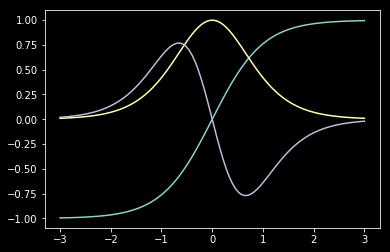

In [48]:
# function and second derivative
xrange=np.linspace(-3,3,100)
x=torch.tensor(xrange,requires_grad=True)
y=torch.tanh(x)
# output f(x), input x, grad_outputs=defines shape
# create graph for derivative calculation 
ox=torch.ones_like(x)
a=torch.autograd.grad(outputs=y, inputs=x, 
                      grad_outputs=ox,
                      create_graph=True)[0] # returns a 1-dim list
y.backward(ox,retain_graph=True)
plt.plot(xrange, y.detach().numpy())
plt.plot(xrange, x.grad.numpy())
x.grad.data.zero_()
a.backward(torch.ones_like(x))
plt.plot(xrange, x.grad.numpy())

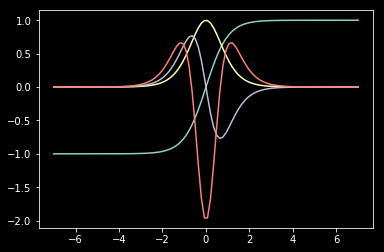

In [49]:
# function and third derivative
xrange=np.linspace(-7,7,100)
x=torch.tensor(xrange,requires_grad=True)
y=torch.tanh(x)
# output f(x), input x, grad_outputs=defines shape
# create graph for derivative calculation 
ox=torch.ones_like(x) # derivative pattern
a=torch.autograd.grad(outputs=y, inputs=x, 
                      grad_outputs=ox,
                      create_graph=True)[0] # returns a 1-dim list
b=torch.autograd.grad(outputs=a, inputs=x, 
                      grad_outputs=ox,
                      create_graph=True)[0] # returns a 1-dim list
y.backward(ox,retain_graph=True)
plt.plot(xrange, y.detach().numpy())
plt.plot(xrange, x.grad.numpy())
x.grad.data.zero_()
a.backward(ox,retain_graph=True)
plt.plot(xrange, x.grad.numpy())
x.grad.data.zero_()
b.backward(torch.ones_like(x),retain_graph=True)
plt.plot(xrange, x.grad.numpy())

x tensor(-2.) - x.grad None
y tensor(-0.9640)
--- grad ---
a
x tensor(-2.) - x.grad None
--- backward ---
x tensor(-2.) - x.grad tensor(0.1362)


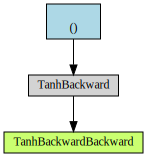

In [53]:
# torch.autograd.grad for higher derivatives
x = torch.tensor(-2., requires_grad=True)
y = torch.tanh(x)
print 'x',x,'- x.grad',x.grad
print 'y',y
print '--- grad ---'
# create graph as any other operation that can be passed by x.backward later
a=torch.autograd.grad(outputs=y, inputs=x, grad_outputs=torch.ones_like(x),create_graph=True)[0] # 3*x**2 returns a 1-dim list
print 'a'
print 'x',x,'- x.grad',x.grad
#not need x.grad.data.zero_()
print '--- backward ---'
a.backward(torch.ones_like(x)) # 2*3*x - x,grad is now second derivative
print 'x',x,'- x.grad',x.grad
make_dot(a)